This post is the start of a series on lossless audio compression. 
The **F**ree **L**ossless **A**udio **C**odec, better known as 
[FLAC](https://en.wikipedia.org/wiki/FLAC), is arguably the most 
common point of contact with this area of computer science. 
My goal is to build a lossless audio coder in Python following 
[Gerald Schuller's book "Filter Banks and Audio Coding"](https://doi.org/10.1007/978-3-030-51249-1).
I will recap a few ideas that I've learned from the book and 
put my own spin on the implementation. 

I'm planning to cover at least the following aspects:

* Explain a lossless audio coding scheme based on Chapter 7 of Schuller's book.
* Implement the **predicitve coding algorithm** from chapter 3.3.6 of Schuller's book.
* Write a **Golomb-Rice coder** from scratch to replace the one from the `audio.coders` library used in Schuller's book.
* Write a replacement for `BitStream` from the `bitstream` to produce byte code. 
* Put all of the above together to obtain a simple lossless audio coder and compare its performance to FLAC.

Once this is done, I want to experiment with deep learning in the context of predictive coding to see if I can beat the classical normalized least mean squares approach. 

As for the format, I haven't made up my mind yet whether I want to make this a proper series of posts or a series of updates to this one. Time will tell. Let's get started...

## Backstory: Why Audio Coding?

### Recollections of the Napster Era
If I had to name the inventions that impacted my life the most, I would probably name personal computers, broadband internet, and last but not least: audio and video coding. As a 12-year-old, I fell in love with music and a little later I got hooked watching sitcoms on TV. The file sharing boom in the early and mid 2000s, as immoral and illegal it was, opened my eyes in many ways. I discovered whole new genres of music and saw and heard my favorite TV shows in their original language for the first time. I would even go as far as saying that I learned most of my English from watching shows like Friends, Seinfeld, Frasier, and Scrubs. But enough about video, I want to focus on music.

Coming from "silly" techno of the Blümchen era (which I still love), UK breakbeat hardcore, jungle and hip hop, I got into a huge progressive rock phase after one of my sister's friends introduced my to Dream Theater. He only played [one song](https://www.youtube.com/watch?v=OLB7JYl34y4) and six months later I was familiar with the entire discographies of bands like Pink Floyd, Yes, Genesis, and Dream Theater, obviously. None of this would have happened without two letters and one number: [MP3](https://en.wikipedia.org/wiki/MP3). 

It helps to remember that a minute of CD quality stereo audio occupies around 10 MB of memory. In comparison, one minute stereo MP3 file encoded at a bitrate of 128 kpbs (= kilobits per second) only takes up 1 MB. This is a reduction in size by a factor of 10! Back in 2002, I was already old enough to appreciate *what* the MP3 format had accomplished, but it essentially remained a mystery to me *how* exactly this was achieved until this year, 2025. In hindsight, I could have understood it much sooner, but I didn't really try, and I probably wouldn't have had the time.

### How I Accidentally Got into Audio Coding

Speaking of having time. After I decided to leave academia in 2024, I went all in on becoming good at programming, data analysis and machine learning. But I also devoted some time to learning about things I've always wanted to know. Among other things, I read about acoustics and digital signal processing. In doing so, I accidentally discovered the research areas [music information retrieval](https://en.wikipedia.org/wiki/Music_information_retrieval) and [audio coding](https://www.audiolabs-erlangen.de/research/audio-coding). As it so happens, the digital signal analysis and processing is an excellent playground for the aforementioned programming, data analysis, and machine learning, allowing me to convince myself that I was not wasting my time. 

One day this summer I went on YouTube and searched for something like "deep learning audio processing". Some of the search results were rather informative and entertaining, but ultimately a little too shallow for my math brain. Luckily, the YouTube algorithm did a good job for once and subsequently pointed me to [Renato Profeta's channel](https://www.youtube.com/@the-sound-travels) who had uploaded video tutorials for various university courses he had taught at the [TU Ilmenau](https://www.tu-ilmenau.de/en/). At the time, Renato was a PhD student of a certain [Prof. Gerald Schuller](https://www.tu-ilmenau.de/universitaet/fakultaeten/fakultaet-elektrotechnik-und-informationstechnik/profil/institute-und-fachgebiete/fachgebiet-angewandte-mediensysteme/team). 

From there on, it didn't take long until I found the aforementioned book which I highly recommend:

 * [Gerald Schuller - Filter Banks and Audio Coding: Compressing Audio Signals Using Python (Springer, 2020)](https://doi.org/10.1007/978-3-030-51249-1)

The book is essentially a tutorial on designing and implementing audio codecs (such as MP3 or FLAC) in Python - which happens to be my main programming language. But it also goes quite deep into the mathematics of signal processing and data compression. What you're reading here is the result of me spending some time with the book.

By the way, if reading is not your thing, you can also go to [Prof. Schuller's YouTube channel](https://www.youtube.com/@profdr-inggeraldschuller-m5126) and watch his [lectures on audio coding](https://www.youtube.com/watch?v=Z28cSk93F6Y&list=PL5QfKiTKGyfu7MipwYAoaAEGCh65LuBQk). The code examples discussed in the lectures are also available on the [GitHub page of the Applied Media Systems Group](https://github.com/TUIlmenauAMS) at TU Ilmenau.

As a last bit of general rambling, I recently found out that one of my favorite classmates from my university days in Bonn, [Jonathan Pfaff](https://www.uni-potsdam.de/en/cs/news/detail/2025-03-24-welcome-prof-jonathan-pfaff), is now a professor for machine learning and data compression, and co-leads the [video coding group](https://www.hhi.fraunhofer.de/abteilungen/vca/forschungsgruppen/videokodierungstechnologien/team.html) at the Fraunhofer HHI in Potsdam. It looks like the [index theory of elliptic operators on manifolds](https://en.wikipedia.org/wiki/Atiyah%E2%80%93Singer_index_theorem) is not our only shared interest anymore. 

## A Glimpse of Audio Coding

Alright, enough of rambling. Let's begin with a general observation about audio signals. Recall that in 16-bit audio every sample can be one of $2^{16} = 65536$ numbers. Typically, these numbers are interpreted as the integers between -32768 and 32767, and it takes two full bytes to store this information. Technically, it is possible that the extremal values appear in adjacent samples, for example, in a white noise signal. But music and speech signals tend to behave more like graphs of continuous function, and such drastic jumps are unlikely to occur frequently. Chances are that the differences between adjacent samples are rather small.

Let's look at an example of a music signal. The blue graph shows the original waveform, and the orange graph shows the differences between adjacent samples. Note that the amplitudes in the differences signal are significantly smaller. In fact, the passage to the differences signal reduces the maximal amplitude roughly by a factor of 3 in this example.

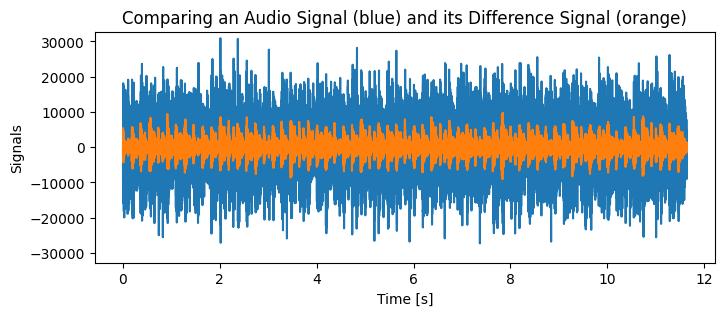

Maximal amplitude in original signal (blue):       30934
Maximal amplitude in differences signal (orange):  9754
Ratio of maximal amplitudes (blue/orange):         3.2 (~10 dB)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# load audio file into NumPy array (keep only left channel, for simplicity)
audio_example = "../audio/lights_out.wav"
y_stereo, sr = librosa.load(audio_example, sr=None, mono=False, dtype=np.int16)
y = y_stereo[0,:]
# compute difference signal
z = y - np.roll(y, 1)
z[0] = y[0]
# plot against time
t = np.arange(len(y)) / sr
fig, ax = plt.subplots(figsize=(8,3))
ax.set_title("Comparing an Audio Signal (blue) and its Difference Signal (orange)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signals")
ax.set_ylim(-2**15, 2**15 - 1)
ax.plot(t,y)
ax.plot(t,z)
plt.show()
print(f"Maximal amplitude in original signal (blue):       {int(np.abs(y).max())}")
print(f"Maximal amplitude in differences signal (orange):  {int(np.abs(z).max())}")
print(f"Ratio of maximal amplitudes (blue/orange):         {np.abs(y).max() / np.abs(z).max():0.1f} (~10 dB)")


A little more systematically, we can think of the original signal as a function $y\colon \Z\to \Z$ which is zero values outside the range $[0:N] = \{n\in\Z\mid 0\le n < N\}$ where $N$ is the number of samples. The differences signal is then given by
$$ z\colon \Z\to \Z,\quad z[n] = y[n] - y[n-1].$$
Note that we can recover $y$ from $z$ recursively by observing that $y[0] = z[0]$ and $y[n] = y[n-1] + z[n]$ for $n\ge1$. 
I'll refer to the passages from $y$ to $z$ and back to $y$ as **encoding** $y$ and **decoding** $z$, respectively.

In the above example the crucial observation is that the encoded signal $z$ never exceeds $2^{14}-1=16383$ in absolute value. This means that, in theory, 15 bits would be sufficient to store the differences. This bitdepth reduction would reduces the required memory to store the original signal $y$ by a factor of $15/16 = 0.9375$. Admittedly, this is not a lot, but it's not nothing, either.

The take-away-message is that it is possible to exploit features of audio signals to encode the signal in such a way that 
(a) original signal can be faithfully reconstructed from the encoded signal, and
(b) the encoded signal requires less memory. 
This is the starting point for **lossless audio compression**.

### Some Really Smart Ideas

**Predictive coding** exploits the fact that music and speech signals tend to be somewhat predictable. Given a suitable number of samples, one can take an educated guess what the next sample might be. And instead of storing the sample values, one can store the difference from the predicted values. 
Schuller explains several prediction algorithms in Chapter 3 of his book. I'll go through the implementation of one of them (based on least mean squares and stochastic gradient descent) later.


**Entropy coding** is a general principle of data compression. As Schuller puts it: 
> *"The goal of an Entropy coder is to minimize the total number of necessary bits for the ﬁle, to obtain the best compression." (Schuller, Chapter 5.1, p. 149)*

To achieve this, features of the signal's distribution (that is, the relative frequencies with which values occur) are exploited. Schuller mentions two entropy coding strategies: 
[Huffman coding](https://en.wikipedia.org/wiki/Huffman_coding) (Chapter 5.2) and 
[Golomb-Rice coding](https://en.wikipedia.org/wiki/Golomb_coding#Rice_coding) (Chapter 5.3). 
Unfortunately, the discussion in the book is somewhat superficial, and I'll probably have to consult other references for my implementation.

These are already the main building blocks of simple **lossless audio coders** which attempt to reduce the memory size required store an audio signal without any loss of information. I'll just briefly mention that the theory behind **lossy audio coders** such as MP3 is considerably more complicated. Some relevant buzzwords include multirate signal processing, specialized filter banks, and various psychoacoustic masking phenomena. All of this is beyond the scope of this series.

## A Template for Lossless Audio Coders

I'll end this post with a template implementation for lossless audio coders. The general idea is to use as few bits as possible to store every sample by exploit general features of audio signals. For a simple lossless audio coder, the following components are sufficient:

* An audio prediction algorithm
* A data compression algorithm
* A way to convert the output of the latter into file-writable byte code

In my implementation I'm going to take an object oriented approach and model each of these components as a Python class. Here's some template code to illustrate my approach. I'll write some more comments in the code.

In [15]:
import numpy as np 

class AudioSignal:
    """A shell class for audio signals. Stores the audio samples
    in a NumPy array as well as the sample rate. Not needed, but
    I like to have it."""
    def __init__(self, x:np.ndarray, sr:int=44100):
        self.samples = x
        self.sr = sr 

class Predictor:
    """Dummy audio prediction algorithm."""
    def encode(self, audio_signal:AudioSignal): pass
    def decode(self, integer_array): pass

class Compressor:
    """Dummy data compression algorithm."""
    def compress(self, integer_array): pass
    def extract(self, bit_code): pass

class ByteCoder:
    """Dummy"""
    def encode(self, bit_code): pass
    def decode(self, byte_code): pass

class LosslessAudioCoder:
    """Dummy template for a predictive lossless audio coder."""
    
    # The three main components are global attributes:
    predictor = Predictor() 
    compressor = Compressor()
    byte_coder = ByteCoder()

    def encode(self, audio_signal:AudioSignal):
        """Method to encode an audio signal to compressed byte code."""
        # extract sample data and sample rate
        audio_samples = audio_signal.samples
        sr = audio_signal.sr 
        # run audio prediction algorithm
        prediction_error = self.predictor.encode(audio_samples)
        # run compression algorithm to obtain a sequence of bits
        compressed_bit_code = self.compressor.compress(prediction_error)
        # produce byte code from the above bit sequence and some metadata
        # NOTE: I think the bitlegth is needed, but I'm not sure
        metadata = {"sr":sr, "bitlength":len(compressed_bit_code)}
        byte_code = self.byte_coder.write(metadata, compressed_bit_code)
        return byte_code
    
    def decode(self, compressed_data):
        """Method to recover an audio signal from compressed byte come."""
        # restore bit sequence and sample rate from byte code
        bit_code, sr = self.byte_coder.read(compressed_data)
        # extract predictor output from bit sequence
        prediction_error = self.compressor.extract(bit_code)
        # decode predictor output to recover audio samples
        audio_samples = self.predictor.decode(prediction_error)
        # return the restored audio signal
        return AudioSignal(audio_samples, sr)


As the code shows, once the components are available, the implementation of the audio coder is straight forward. 

This is all for now. In the next post (or update) I'll discuss the prediction algorithm discussed in Chapter 3.3.6 of Schuller's book.